# Spaceship Titanic

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Framing the problem

The object of this task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic'c collision with the spacetime anomaly.

This is a classic classification task, wchich requires supervised, offline learning.

The performance should be measured as a precision score.

75% precision score would be a satisfactory result

### Getting the data

In [3]:
train_kaggle = pd.read_csv(r'datasets\spaceship-titanic\train.csv')
test_kaggle = pd.read_csv(r'datasets\spaceship-titanic\test.csv')

### Exploring the data

In [4]:
train_kaggle.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>],
       [<AxesSubplot:title={'center':'FoodCourt'}>,
        <AxesSubplot:title={'center':'ShoppingMall'}>],
       [<AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>]], dtype=object)

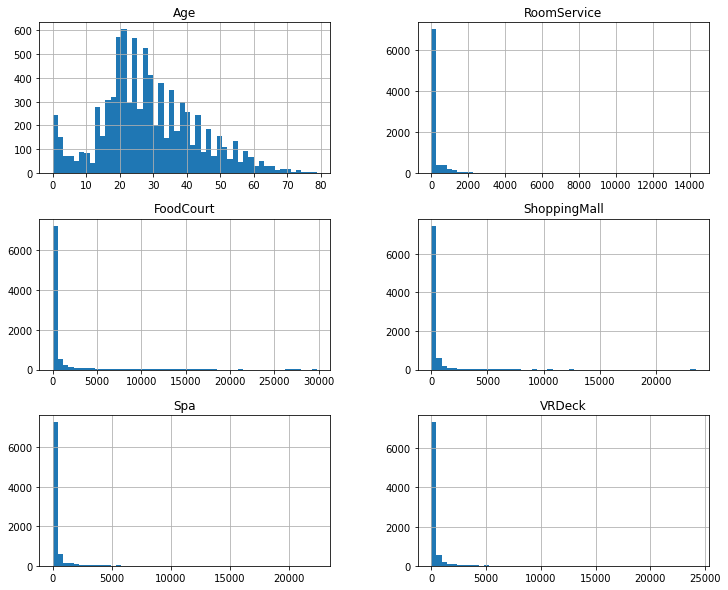

In [5]:
train_kaggle.hist(figsize=(12, 10), bins=50)

Passenger ID may be interesting. It is constructed as gggg_pp where gggg is a group the passenger is travelling with and the pp is a passenger number within this group.

Maybe it would be heplful to extract the group number and add it to the table

In [6]:
train_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
train_kaggle.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
for category in train_kaggle.columns.values:
    missing_percent = train_kaggle[category].isnull().sum() / train_kaggle[category].size
    print(f"{category:15} {missing_percent:.2%}")

PassengerId     0.00%
HomePlanet      2.31%
CryoSleep       2.50%
Cabin           2.29%
Destination     2.09%
Age             2.06%
VIP             2.34%
RoomService     2.08%
FoodCourt       2.11%
ShoppingMall    2.39%
Spa             2.11%
VRDeck          2.16%
Name            2.30%
Transported     0.00%


In [9]:
train_kaggle['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [10]:
train_kaggle['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [11]:
train_kaggle['Cabin'].value_counts() 

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

Cabin seems to be irrelevant in the form it is now presented. Due to the fact that it is contructed as a deck/num/side, maybe I should transform it to 'deck', 'num' and 'side' columns.

In [12]:
train_kaggle['Destination'].value_counts() 

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [13]:
train_kaggle['RoomService'].value_counts() 

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: RoomService, Length: 1273, dtype: int64

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck are the amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

I'm not sure now if it this information has any meaning in this task

In [48]:
train_kaggle["Group"] = np.nan
train_kaggle["Deck"] = np.nan
train_kaggle["Num"] = np.nan
train_kaggle["Side"] = np.nan

In [52]:
for i, person in train_kaggle.iterrows():
    group = person['PassengerId'].split('_')[0]
    train_kaggle.at[i, 'Group'] = group

    try:
        deck, num, side = person['Cabin'].split('/')
        train_kaggle.at[i, 'Deck'] = deck
        train_kaggle.at[i, 'Num'] = num
        train_kaggle.at[i, 'Side'] = side
    except AttributeError:
        pass

train_kaggle.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S


In [53]:
train_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   object 
 15  Deck          8494 non-null   object 
 16  Num           8494 non-null   object 
 17  Side          8494 non-null   object 
dtypes: bool(1), float64(6), obje

In [57]:
train_kaggle['Deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

In [45]:
corr = train_kaggle.corr()
corr['Transported'].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.046566
ShoppingMall    0.010141
Num            -0.045097
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64